# <center>This `.ipynb` file contains the code for showing sampling results after finetuning1</center>

### 1. Import the required libraries

In [1]:
import torch
from torch import nn

from torchvision import transforms
from torchvision.utils import make_grid

import sys
import os
import random
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.insert(0, '..')
from pfiles.unet_cond_base import UNet
from pfiles.vqvae import VQVAE
from pfiles.linear_noise_scheduler import LinearNoiseScheduler

### 2. Define the device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is:', device)

Device is: cuda


### 3. Set different hyperparameters

In [3]:
seed = 765

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
num_timesteps = 1000
beta_start = 0.0001
beta_end = 0.02

In [5]:
select_batch_size = 16
rgb_input = 3
z_channels = 16
n_clusters = 14 # change it to 10, 11, 12, 13, 15, or 16 for other partitions

image_size = 128
num_samples = 5

### 4. Load the dataset

In [6]:
dir_src = '/project/dsc-is/nono/Documents/kpc/dat0'
data_src = 'slice128_Block2_11K.npy'

print(os.path.join(dir_src, data_src))

kpc_dataset = np.load(os.path.join(dir_src, data_src))
kpc_dataset = kpc_dataset[:, 0, :, :, :]

print(kpc_dataset.shape)
N_SAMPLE, HEIGHT, WIDTH, CHANNELS = kpc_dataset.shape

/project/dsc-is/nono/Documents/kpc/dat0/slice128_Block2_11K.npy
(11000, 128, 128, 3)


In [7]:
index_range = np.arange(N_SAMPLE)
split = np.array_split(index_range, 11)
test_dataset = split[10]
training_dataset = np.setdiff1d(index_range, test_dataset)

In [8]:
print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 10000
Length of the test dataset: 1000


### 5. Custom functions for extracting batches of samples from the dataset

In [9]:
def make_batch_list(idx, n_batch=10, batch_size=None, shuffle=True):
    if shuffle:
        np.random.shuffle(idx)
    if batch_size is not None:
        n_batch = len(idx) // batch_size
    batch_list = np.array_split(idx, n_batch)
    return batch_list

In [10]:
transform = transforms.ToTensor()

def generate_batch(idx, kpc_dataset):
    tmp = []
    for i in idx:
        xxx = transform(kpc_dataset[i])
        tmp.append(xxx)
    xxx_batch = torch.stack(tmp, dim=0)
    return xxx_batch

### 6. Set up directory for saving models

In [11]:
task_name = 'models_14'

if not os.path.exists(task_name):
    os.mkdir(task_name)

### 7. Neural network for deep learning-based clustering

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.classifier = nn.Sequential()
        self.classifier.add_module('conv1', nn.Conv2d(in_channels=z_channels, out_channels=128, kernel_size=4, stride=2,
                                                      padding=1))
        self.classifier.add_module('bnor1', nn.BatchNorm2d(num_features=128, affine=True, track_running_stats=True))
        self.classifier.add_module('lrel1', nn.LeakyReLU(negative_slope=0.1, inplace=True))
        self.classifier.add_module('conv2', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1))
        self.classifier.add_module('bnor2', nn.BatchNorm2d(num_features=128, affine=True, track_running_stats=True))
        self.classifier.add_module('lrel2', nn.LeakyReLU(negative_slope=0.1, inplace=True))
        self.classifier.add_module('conv3', nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1))
        self.classifier.add_module('lrel3', nn.LeakyReLU(negative_slope=0.1, inplace=True))
        self.classifier.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=n_clusters, kernel_size=4, stride=1,
                                                      padding=0))
        self.classifier.add_module('lrel4', nn.LeakyReLU(negative_slope=0.1, inplace=True))
        
    def forward(self, lat):
        out = self.classifier(lat)
        return out

### 8. Instantiate `UNet`, `VQVAE`, and `Classifier` architecture

In [13]:
model = UNet(im_channels=z_channels, cls=n_clusters).to(device)
model.eval()
print('Loaded unet training checkpoint')
model.load_state_dict(torch.load(os.path.join(task_name, 'unet_additional_ckpt_20250128_130_14.pth'), map_location=device,
                                     weights_only=True))

Loaded unet training checkpoint


<All keys matched successfully>

In [14]:
vq_vae = VQVAE(im_channels=rgb_input).to(device)
vq_vae.eval()
print('Loaded vq_vae checkpoint')
vq_vae.load_state_dict(torch.load(os.path.join('../kpc_ldm', 'vqvae_autoencoder_ckpt.pth'), map_location=device,
                                  weights_only=True))

Loaded vq_vae checkpoint


<All keys matched successfully>

In [15]:
model_cl = Classifier().to(device)
model_cl.eval()
print('Loaded model_cl training checkpoint')
model_cl.load_state_dict(torch.load(os.path.join(task_name, 'classifier_ckpt_20250127_600_14.pth'), map_location=device,
                                    weights_only=True))

Loaded model_cl training checkpoint


<All keys matched successfully>

### 9. Prepare to show sampling results after finetuning1

In [16]:
select_test_index = [10691, 10755, 10467, 10733, 10979]
test_xxx = generate_batch(select_test_index, kpc_dataset)
test_xxx.shape

torch.Size([5, 3, 128, 128])

In [17]:
test_xxx = test_xxx.to(device)
test_im, _ = vq_vae.encode(test_xxx)
test_out_cl = model_cl(test_im)
test_cond_input = torch.argmax(test_out_cl.reshape((-1, n_clusters)), dim=1)

### 10. Custom function to conditionally generate samples

In [18]:
def cond_sample(model, scheduler, vq_vae):
    
    im_size = image_size // 2 ** sum([True, True])
    xt = torch.randn((num_samples, z_channels, im_size, im_size)).to(device)
    
    for i in tqdm(reversed(range(num_timesteps))):
        
        t = (torch.ones((xt.shape[0],)) * i).long().to(device)
        noise_pred = model(xt, t, test_cond_input)
        
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        if i==0:
            ims = vq_vae.decode(xt)
        else:
            ims = xt
            
    return ims

### 11. Instantiate `linear` scheduler

In [19]:
scheduler = LinearNoiseScheduler(num_timesteps=num_timesteps, beta_start=beta_start, beta_end=beta_end)

### 12. Sampling after finetuning1

In [20]:
with torch.no_grad():
    obtained_samples = cond_sample(model=model, scheduler=scheduler, vq_vae=vq_vae)

1000it [00:21, 46.61it/s]


### 13. Visualize generated and test samples

In [21]:
obtained = torch.clamp(obtained_samples, min=0., max=1.).detach().cpu()
obtained_grid = make_grid(obtained)

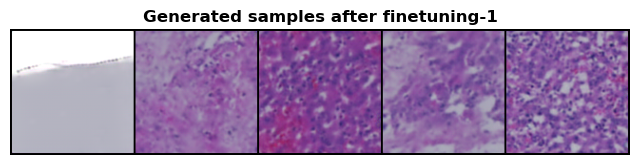

In [22]:
plt.figure(figsize=(8, 4))
plt.imshow(obtained_grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Generated samples after finetuning-1', fontweight='bold');

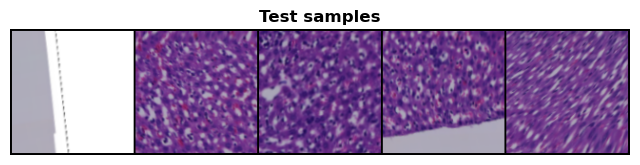

In [23]:
plt.figure(figsize=(8, 4))
o = make_grid(test_xxx.detach().cpu(), nrow=10)
plt.imshow(o.permute(1, 2, 0))
plt.title('Test samples', fontweight='bold');
plt.axis(False);